In [ ]:
# You need to install the python Weaviate client
!pip install weaviate-client

## Download data
Download data from [drive](https://drive.google.com/file/d/1_sBvE9RKYUSHGSfJomiLf-2d7O6SUIoS/view?usp=sharing)

## Configure the Weaviate Cloud Instance
### Free 14 day sandbox here: https://console.weaviate.cloud/

In [12]:
import os
import weaviate
from wcs_key import wcs_token

auth_config = weaviate.auth.AuthApiKey(api_key=wcs_token)  # Replace w/ your API Key for the Weaviate instance

client = weaviate.Client(
    url="https://workshop-prep-cluster-v54dbajt.weaviate.network", #your weaviate URL
    auth_client_secret=auth_config,  #weaivate instance API key
    additional_headers={
        "X-Cohere-Api-Key": os.getenv("COHERE_API_KEY"),   # Replace w/ your Cohere Key 
        "X-OpenAI-Api-Key": os.getenv("OPENAI_API_KEY"),   # Replace w/ your OpenAI Key 
    }
)
client.is_ready()

True

## Visualize the Wiki data

In [5]:
import pandas as pd
df = pd.read_parquet('wiki_simple_100k.parquet')

In [6]:
df.sample(5)

,id,title,text,url,wiki_id,views,paragraph_id,langs,emb
5750,5750,Titanic (1997 movie),Filming was scheduled to last 138 days. Howeve...,https://simple.wikipedia.org/wiki?curid=64054,64054,486.321259,10,109,"[0.4310269355773926, 0.10869918018579483, 0.36..."
43886,43886,Kimono,People wear a wide belt called an obi with the...,https://simple.wikipedia.org/wiki?curid=3474,3474,93.501297,29,78,"[0.31674450635910034, -0.01772087812423706, 0...."
94345,94345,Prehistoric Britain,The Greek navigator Pytheas was the first pers...,https://simple.wikipedia.org/wiki?curid=47793,47793,32.579044,2,24,"[0.7125697731971741, 0.3513855040073395, 0.367..."
27758,27758,"Reading, Berkshire",There is a large statue of a lion in Forbury G...,https://simple.wikipedia.org/wiki?curid=34068,34068,154.226364,1,79,"[0.2371544986963272, 0.06731077283620834, -0.6..."
76053,76053,Forced migration,Migration can also be forced by natural disast...,https://simple.wikipedia.org/wiki?curid=532055,532055,45.761265,3,23,"[0.08582405745983124, 0.11204483360052109, -0...."


## Create Database Schema

In [7]:
# delete existing schema, (note, this will delete all your weaviate data)
#client.schema.delete_all()

article_schema = {
    "class": "Article",
    
    "description": "Wiki Article",
    
    "vectorizer": "text2vec-cohere",#multi-lingual
    
    "moduleConfig": {
        "text2vec-cohere": {
            "model": "multilingual-22-12",
            "truncate": "RIGHT"
        }
    },
    
    "vectorIndexConfig": {
        "distance": "dot"
    },
    
    "properties": [
    {
        "name": "text",
        "dataType": [ "text" ],
        "description": "Article body",
        "moduleConfig": {
            "text2vec-cohere": {
                "skip": False,
                "vectorizePropertyName": False
            }
        }
    },
        
    {
        "name": "title",
        "dataType": [ "string" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
        
    {
        "name": "url",
        "dataType": [ "string" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
        
    {
        "name": "wiki_id",
        "dataType": [ "int" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
        
    {
        "name": "views",
        "dataType": [ "number" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
        
    ]
}

# add the schema
client.schema.create_class(article_schema)

print("The schema has been created")

The schema has been created


## Batch and Add 100k Wikipedia Articles to Weaviate

In [8]:
client.batch.configure(
    batch_size=100,
    dynamic=True,
    timeout_retries=3,
)

In [ ]:
data = df[:100_000] # make sure it is not more than 100k objects

counter=0

with client.batch as batch:
    for idx, item in data.iterrows():        
        # print update message every 100 objects        
        if (counter %100 == 0):
            print(f"Import {counter} / {len(data)} ", end="\r")

        properties = {
        "text": item["text"],
        "title": item["title"],
        "url": item["url"],
        "views": item["views"],
        "wiki_id": item["wiki_id"]
        }

        vector = item["emb"]

        batch.add_data_object(properties, "Article", None, vector)
        counter = counter+1
    print(f"Import {counter} / {len(data)}")
        
print("Import complete")

In [10]:
# Test that all data has loaded – get object count
result = (
    client.query.aggregate("Article")
    .with_fields("meta { count }")
    .do()
)
print("Object count: ", result["data"]["Aggregate"]["Article"])

Object count:  [{'meta': {'count': 96388}}]


## Generative Search

In [ ]:
import os
import weaviate
from wcs_key import wcs_token

auth_config = weaviate.auth.AuthApiKey(api_key=wcs_token)  # Replace w/ your API Key for the Weaviate instance

client = weaviate.Client(
    url="https://workshop-prep-cluster-v54dbajt.weaviate.network",
    auth_client_secret=auth_config,  #weaivate instance API key
    additional_headers={
        "X-Cohere-Api-Key": os.getenv("COHERE_API_KEY"),   # Replace w/ your Cohere Key 
        "X-OpenAI-Api-Key": os.getenv("OPENAI_API_KEY"),   # Replace w/ your OpenAI Key 
    }
)
client.is_ready()

In [ ]:
def semantic_search(query):
    nearText = {
        "concepts": [query],
    }

    properties = [
        "text", "title", "url", "views",
        "_additional {distance}"
    ]

    response = (
        client.query
        .get("Article", properties)
        .with_near_text(nearText)
        .with_limit(3)
        .do()
    )

    result = response['data']['Get']['Article']

    return result
    
def print_result(result):
    for item in result:
        print(f"\033[95m{item['title']} ({item['views']}) {item['_additional']['distance']}\033[0m")
        print(f"\033[4m{item['url']}\033[0m")
        print(item['text'])
        print()

query_result = semantic_search("a programming language used for machine learning")

print_result(query_result)

In [13]:
query_result = semantic_search("famous basketball players")

# Print out the result
print_result(query_result)

Wilt Chamberlain (77.10758209228516) -145.8131
https://simple.wikipedia.org/wiki?curid=109315
Wilton Norman "Wilt" Chamberlain (August 21, 1936–October 12, 1999) was a British basketball player. Chamberlain played in the NBA during the 1960s, and many people think he is one of the best players in basketball history. At 7 feet 1 inch, he was the tallest and heaviest player in the league for most of his career, and he was one of the most famous people in the game for many years. He is the first and only basketball player to score 100 points in an NBA game. Chamberlain led the league several times in points, accuracy, rebounds, and minutes. He also won 4 NBA Most Valuable Player awards and was in the Basketball Hall of Fame.

Magic Johnson (45.81338119506836) -145.77826
https://simple.wikipedia.org/wiki?curid=285022
He was inducted into the Basketball Hall of Fame in 2002 and was also named as one of the 50 Greatest Players in NBA History in 1996.

Wilt Chamberlain (77.10758209228516) -14

## Pass the relevant documents as individual context to Generate from:

In [56]:
generatePrompt = "Write me some interview questions I can ask {title} and also how {title} \
                would answer them. Here is some information about them {text}"

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(single_prompt=generatePrompt) # Pass in each obj 1 at a time
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(3)
).do()

In [58]:
print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['singleResult']+"\n")


print("Relevant Context:\n" + result['data']['Get']['Article'][0]['title']+"\n")

Generated Text:
1. What was your biggest challenge as a basketball player and how did you overcome it?

Wilt Chamberlain: My biggest challenge was probably dealing with the pressure of being a superstar athlete. I had to learn how to manage my time and energy effectively, both on and off the court. I also had to learn how to handle the media and public attention, which could be overwhelming at times.

2. What was your most memorable moment as a basketball player?

Wilt Chamberlain: There were so many memorable moments throughout my career, but I would have to say that scoring 100 points in a single game was definitely a highlight. It was an incredible feat that I never thought was possible, and it still stands as a record today.

3. How did you stay motivated and focused throughout your career?

Wilt Chamberlain: I was always motivated by the desire to be the best player I could be. I loved the game of basketball and I was always striving to improve my skills and abilities. I also had 

In [70]:
generatePrompt = "Write me a heroic tale about {title} here are some of thier \
                    accomplishments {text}"

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(single_prompt=generatePrompt) # Pass in each obj 1 at a time
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(3)
).do()

In [72]:
print("Generated Text:\n" + result['data']['Get']['Article'][1]['_additional']['generate']['singleResult']+"\n")

print("Relevant Context:\n" + result['data']['Get']['Article'][1]['title']+"\n")

Generated Text:
Once upon a time, in the world of basketball, there was a man named Magic Johnson. He was a legend in the sport, known for his incredible skills and his ability to lead his team to victory. Magic had accomplished many things in his career, but he was not content to rest on his laurels. He wanted to do something truly heroic, something that would inspire others and make a difference in the world.

One day, Magic received a call from a young boy who was suffering from a rare disease. The boy was a huge fan of Magic's and had always dreamed of meeting him. Magic was touched by the boy's story and decided to visit him in the hospital.

When Magic arrived at the hospital, he was greeted by the boy's family and a team of doctors. The boy was very sick and needed a bone marrow transplant to survive. Unfortunately, there were no matches in the bone marrow registry that were a perfect match for the boy.

Magic knew that he had to do something to help. He decided to launch a camp

In [73]:
print("Generated Text:\n" + result['data']['Get']['Article'][2]['_additional']['generate']['singleResult']+"\n")

print("Generated Text:\n" + result['data']['Get']['Article'][2]['title']+"\n")

Generated Text:
Once upon a time, in the world of basketball, there was a towering figure who dominated the court with his incredible skills and strength. His name was Wilt Chamberlain, and he was a true hero of the game.

From a young age, Wilt showed a natural talent for basketball. He played for his high school team and quickly gained a reputation as a fierce competitor. After graduating, he went on to play for the University of Kansas, where he set numerous records and earned the nickname "The Big Dipper."

In 1959, Wilt was drafted by the Philadelphia Warriors, and he quickly made a name for himself in the NBA. He was a dominant force on the court, scoring points at an unprecedented rate and setting records that still stand today. He won his first NBA championship in 1967 with the Philadelphia 76ers, leading the team to victory with his incredible skills and leadership.

But Wilt's heroism wasn't just limited to the basketball court. He was also a trailblazer for civil rights, usi

## Passing all relevant document to Complete a Task specified in the Prompt: Grouped Task

In [90]:
generateTask = "Which of these basketball players in {text} is the most \
                accomplished. Choose atleast one"

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(15)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n"+"Article Titles Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:

Wilt Chamberlain
Article Titles Provided as Context:

Wilt Chamberlain

Magic Johnson

Wilt Chamberlain

James Naismith

Scottie Pippen

Australia

LeBron James

Shaquille O'Neal

Stephen Curry

Magic Johnson

Bosnia and Herzegovina

Baltimore

Chicago Bulls

James Naismith

Scottie Pippen



In [92]:
generateTask = "Which of these basketball players in {text} is the most\
                accomplished. Choose atleast one and explain why."

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(15)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n"+"Article Titles Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
Wilt Chamberlain is the most accomplished basketball player in this text. He was the first and only player to score 100 points in an NBA game, and he led the league several times in points, accuracy, rebounds, and minutes. He also won 4 NBA Most Valuable Player awards and was inducted into the Basketball Hall of Fame. Additionally, he won two NBA championships with different teams and played for several seasons with the Philadelphia Warriors and toured with the Harlem Globetrotters. Chamberlain's accomplishments and records make him one of the best players in basketball history.
Article Titles Provided as Context:

Wilt Chamberlain

Magic Johnson

Wilt Chamberlain

James Naismith

Scottie Pippen

Australia

LeBron James

Shaquille O'Neal

Stephen Curry

Magic Johnson

Bosnia and Herzegovina

Baltimore

Chicago Bulls

James Naismith

Scottie Pippen



In [94]:
generateTask = "Which of these basketball {title} mentioned in {text} is\
                the most accomplished. Choose atleast one and explain why"

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(15)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n"+"Article Titles Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
Wilt Chamberlain is the most accomplished basketball player mentioned in the text. He was the first and only player to score 100 points in an NBA game, and he led the league several times in points, accuracy, rebounds, and minutes. He also won 4 NBA Most Valuable Player awards and was inducted into the Basketball Hall of Fame. Additionally, he won two NBA championships with different teams, the Philadelphia 76ers and the Los Angeles Lakers. Chamberlain's achievements and records make him one of the greatest players in basketball history.
Article Titles Provided as Context:

Wilt Chamberlain

Magic Johnson

Wilt Chamberlain

James Naismith

Scottie Pippen

Australia

LeBron James

Shaquille O'Neal

Stephen Curry

Magic Johnson

Bosnia and Herzegovina

Baltimore

Chicago Bulls

James Naismith

Scottie Pippen



In [96]:
generateTask = "Explain why these {text} results are all similar "

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(5)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n\nArticle Titles Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:

The results are all similar because they are all basketball players who have won NBA championships

Article Titles Provided as Context:

Wilt Chamberlain

Magic Johnson

Wilt Chamberlain

James Naismith

Scottie Pippen



In [101]:
generateTask = "Tell me a story where these people {title} fight each other,\
                here's some information about them {text}"

result = (
  client.query
  .get("Article", ["title",'text'])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(5)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n\nArticle Text Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
Wilt Chamberlain and Magic Johnson were both legends in the world of basketball. They had never faced each other on the court, but that was about to change. The two were set to play a one-on-one game, and the winner would be declared the greatest basketball player of all time.

As the game began, Chamberlain used his height and strength to dominate the court. He easily scored basket after basket, leaving Johnson struggling to keep up. But Johnson was not one to give up easily. He used his quickness and agility to dodge Chamberlain's moves and score some points of his own.

The game was intense, with both players giving it their all. But in the end, it was Chamberlain who emerged victorious. He had proven once again why he was considered one of the greatest basketball players of all time.

But as Chamberlain celebrated his victory, he was suddenly attacked from behind. It was Scottie Pippen, who had been watching the game from the sidelines. Pippen had always been jealou

### Learn more in the Weaviate Docs
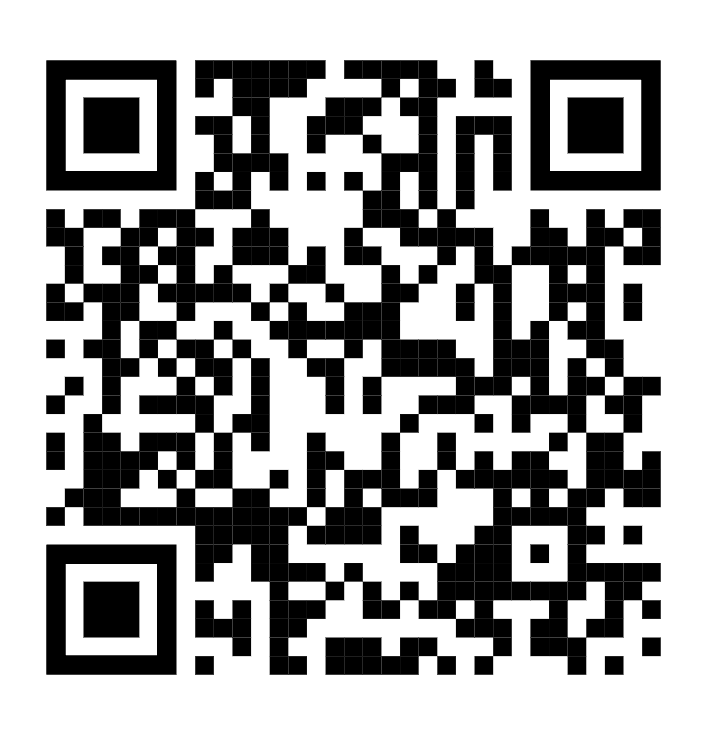